# Configuration

In [1]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import seaborn as sns

import utils.visualization as v

# Pretty display for notebooks
%matplotlib inline

# Autoreload
%load_ext autoreload
%autoreload 2

# No max columns when displaying data frames
pd.options.display.max_columns = None

# SNS config
sns.set()
sns.set_style("white")
#sns.set_palette('bone')

# Load data

## Create reduced dataset

In [2]:
data_raw = pd.read_csv('data/train_V2.csv')

# Filter the solo fpp matches
data = data_raw[data_raw.matchType == 'solo-fpp']

# Drop unnecessary variables
unnecessary_cols = ['Id', 'groupId', 'matchId', 'matchType', 'killPoints', 'rankPoints',
                    'teamKills', 'revives', 'assists', 'numGroups', 'maxPlace', 'DBNOs']
data = data.drop(unnecessary_cols, axis = 1)

# There is a row with winPlacePerc set to NaN
data = data.dropna()

data.to_csv('data/pubg_dataset.csv', index=False)

## Load data

In [3]:
# Load data
data_raw = pd.read_csv('data/pubg_dataset.csv')

---

# Data Preprocessing

In [4]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
boosts,536761.0,1.058980,1.791553,0.0,0.0000,0.0000,2.0000,28.0
damageDealt,536761.0,118.918804,158.345782,0.0,0.0000,75.7900,171.0000,2305.0
headshotKills,536761.0,0.251553,0.633480,0.0,0.0000,0.0000,0.0000,16.0
heals,536761.0,1.009678,2.383454,0.0,0.0000,0.0000,1.0000,63.0
killPlace,536761.0,48.025596,27.579939,1.0,24.0000,48.0000,72.0000,100.0
kills,536761.0,0.934731,1.495987,0.0,0.0000,0.0000,1.0000,23.0
killStreaks,536761.0,0.482457,0.556407,0.0,0.0000,0.0000,1.0000,5.0
longestKill,536761.0,21.701100,45.716959,0.0,0.0000,0.0000,22.0600,940.1
matchDuration,536761.0,1577.081990,249.372334,1044.0,1377.0000,1439.0000,1854.0000,2199.0
rideDistance,536761.0,403.209692,1270.646059,0.0,0.0000,0.0000,0.0000,40710.0


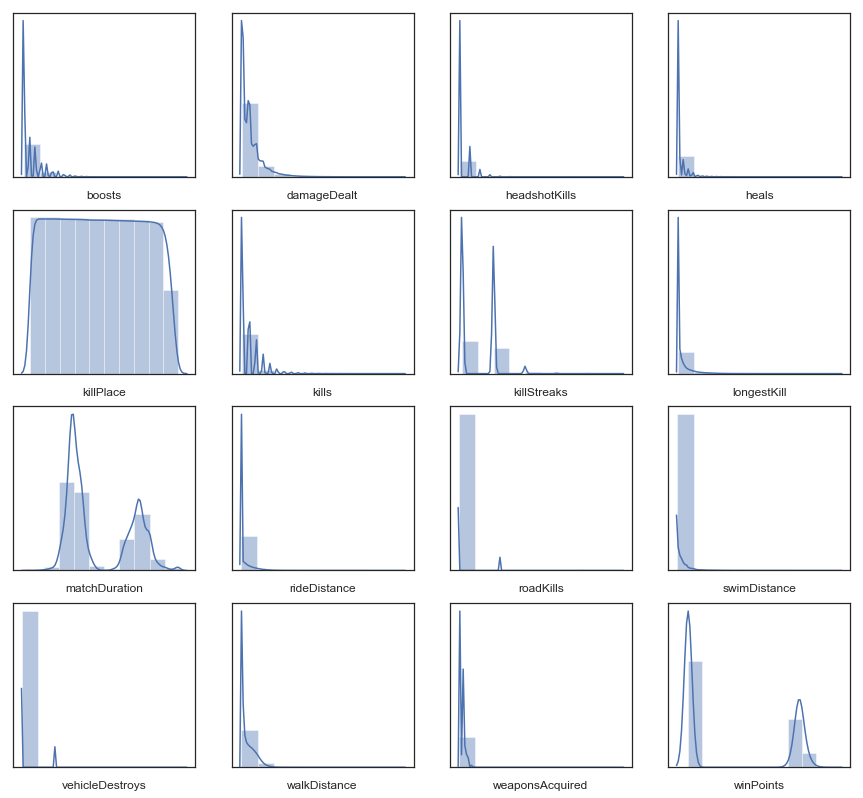

In [5]:
feature_names = data_raw.columns[:-1]

v.distplot_all_cols(data_raw, columns=feature_names, bins=10)

# Preprocessing

## Remove outliers

In [6]:
from collections import Counter

outliers_counter = Counter()

# For each feature find the data points with extreme high or low values
for feature in feature_names:
    # Calculate Q1 and Q3 for the given feature
    Q1 = np.percentile(data_raw[feature], 25)
    Q3 = np.percentile(data_raw[feature], 75)
    
    # Calculate the outlier step
    step = 1.5 * (Q3 - Q1)
    
    # Calculate outliers
    outliers_table = data_raw[(data_raw[feature] < Q1 - step) | (data_raw[feature] > Q3 + step)]
    outliers_counter.update(outliers_table.index)
    
# Select the indices of the ourliers
outliers  = [idx for idx, count in outliers_counter.items() if count >= 5]
print('%d points considered outliers' % len(outliers))

# Remove the outliers
data_no_outliers = data_raw.drop(data_raw.index[outliers]);

23609 points considered outliers


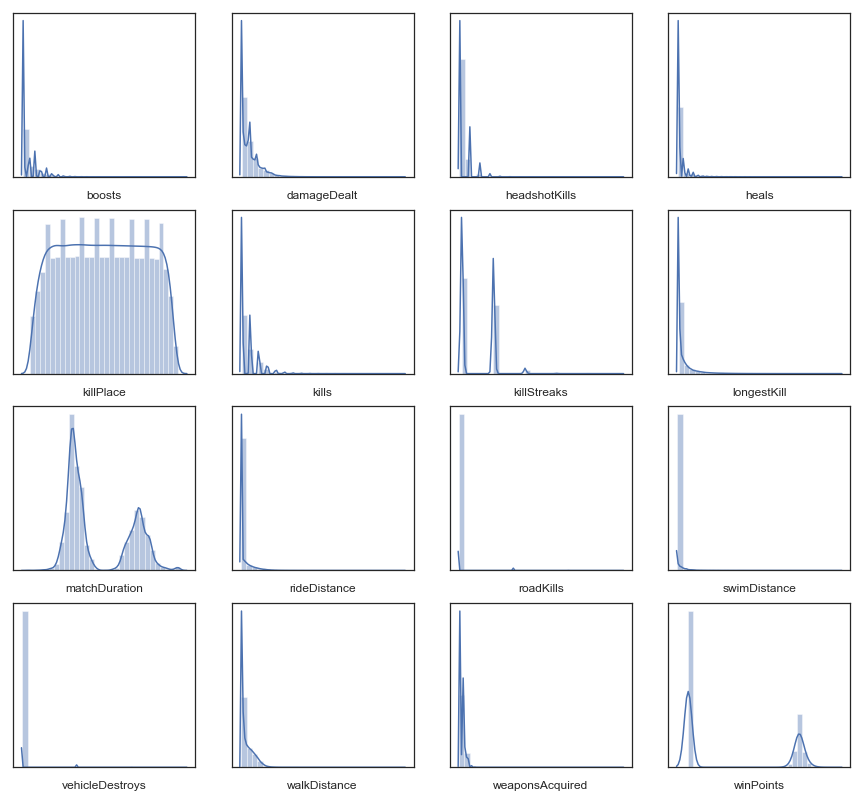

In [7]:
from utils.scaling import min_max_scale
v.distplot_all_cols(data_no_outliers, columns=feature_names, bins=30)

## Transforming skewed features

In [26]:
from scipy import stats

skewed = ['boosts', 'damageDealt', 'headshotKills', 'heals', 'kills', 'killStreaks', 'longestKill',
          'rideDistance', 'roadKills', 'swimDistance', 'vehicleDestroys', 'walkDistance',
          'weaponsAcquired', 'winPoints']

data1 = data_no_outliers.copy()
data1[skewed] = data1[skewed].apply(lambda x: stats.boxcox(x + 1)[0])

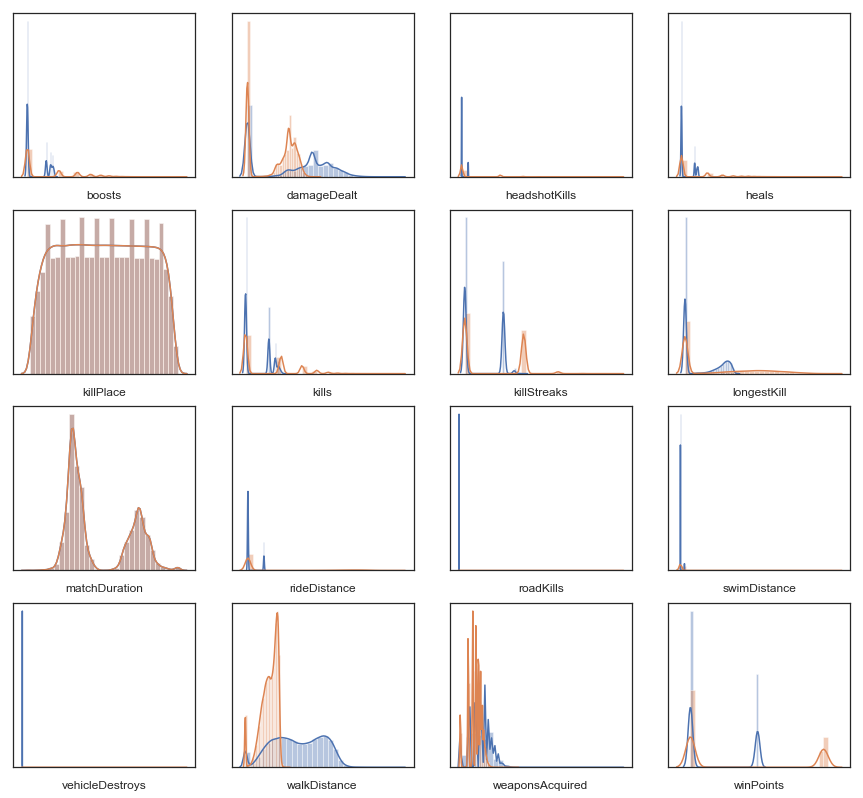

In [27]:
v.distplot_all_cols(data1, data_log_transformed, columns=feature_names, bins=30)

In [10]:
skewed = ['boosts', 'damageDealt', 'headshotKills', 'heals', 'kills', 'killStreaks', 'longestKill',
          'rideDistance', 'roadKills', 'swimDistance', 'vehicleDestroys', 'walkDistance',
          'weaponsAcquired', 'winPoints']

data_log_transformed = data_no_outliers.copy()
data_log_transformed[skewed] = data_log_transformed[skewed].apply(lambda x: np.log(x + 1))

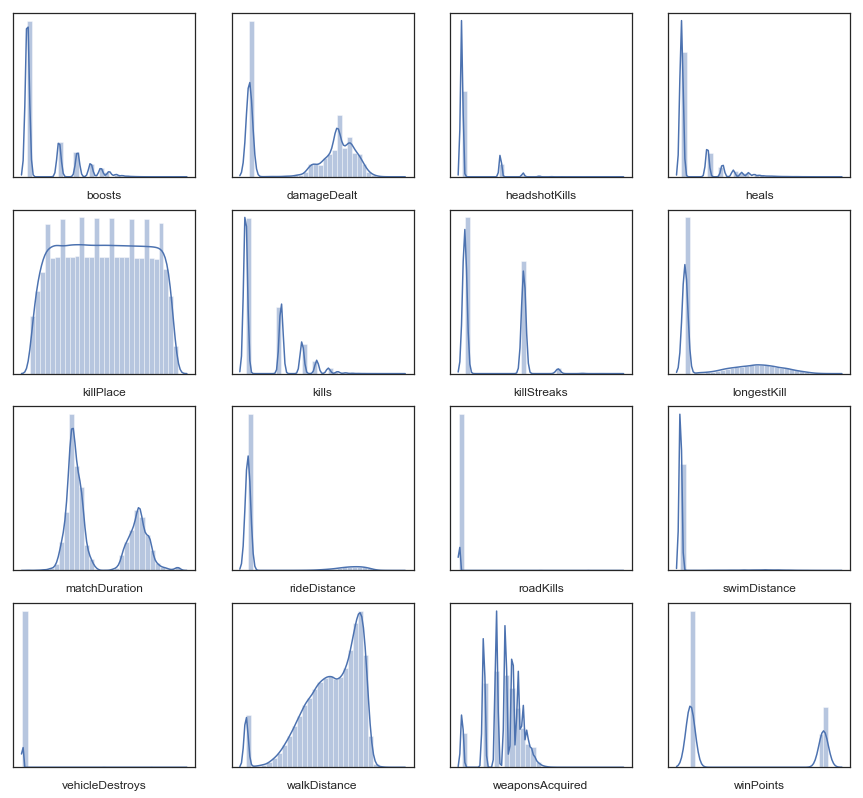

In [11]:
v.distplot_all_cols(data_log_transformed, columns=feature_names, bins=30)

## Normalize features

In [12]:
from utils.scaling import min_max_scale

data_log_minmax_transformed = min_max_scale(data_log_transformed, columns=feature_names)

In [13]:
data_log_minmax_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
boosts,513152.0,0.121795,0.176723,0.0,0.000000,0.000000,0.205847,1.0
damageDealt,513152.0,0.408779,0.302671,0.0,0.000000,0.552952,0.655057,1.0
headshotKills,513152.0,0.041167,0.100868,0.0,0.000000,0.000000,0.000000,1.0
heals,513152.0,0.083063,0.146656,0.0,0.000000,0.000000,0.166667,1.0
killPlace,513152.0,0.495077,0.268171,0.0,0.262626,0.494949,0.727273,1.0
kills,513152.0,0.135305,0.171607,0.0,0.000000,0.000000,0.231378,1.0
killStreaks,513152.0,0.170855,0.199628,0.0,0.000000,0.000000,0.386853,1.0
longestKill,513152.0,0.206850,0.263959,0.0,0.000000,0.000000,0.449413,1.0
matchDuration,513152.0,0.458141,0.214989,0.0,0.287446,0.340260,0.699567,1.0
rideDistance,513152.0,0.105939,0.250420,0.0,0.000000,0.000000,0.000000,1.0


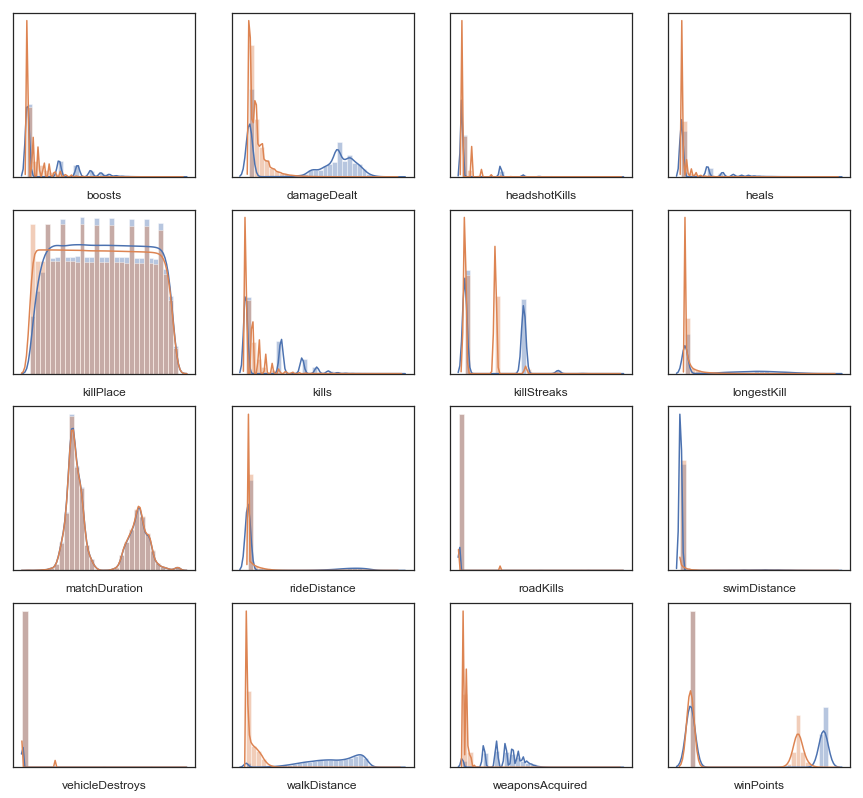

In [14]:
v.distplot_all_cols(data_log_minmax_transformed, min_max_scale(data_raw), columns=feature_names, bins=30)

# Data exploration

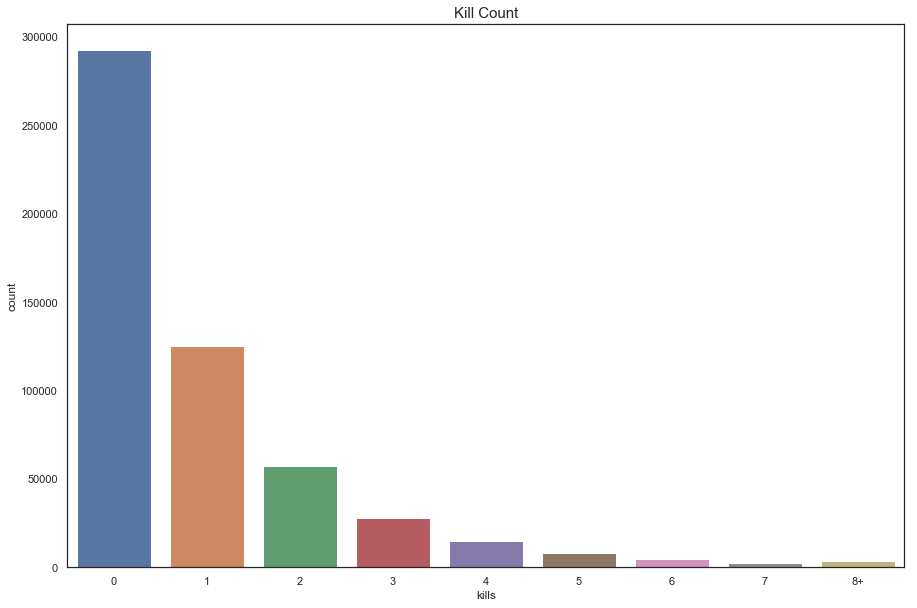

In [15]:
kills = data_raw.copy()
kills.loc[kills['kills'] >= 8] = '8+'

plt.figure(figsize=(15,10))
sns.countplot(kills['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

---

# Create clasifier

In [16]:
from sklearn.metrics import mean_absolute_error
from time import time


def train_predict(learner, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''

    results = {}

    # Fit the learner
    start = time()
    learner = learner.fit(X_train, y_train)
    end = time()

    # Calculate the training time
    results['train_time'] = end - start

    # Predict for the testing and training sets
    start = time()  # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()  # Get end time

    # Calculate the total prediction time
    results['pred_time'] = end - start

    # Compute MAE for the training set
    results['mae_train'] = mean_absolute_error(y_train, predictions_train)

    # Compute MAE for the testing set
    results['mae_test'] = mean_absolute_error(y_test, predictions_test)

    # Return the results
    return results

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

random_state = 1

# Extract winPlacePerc
features = data_raw.drop('winPlacePerc', axis=1)
win_place_perc = data_raw['winPlacePerc']

X_train, X_test, y_train, y_test = train_test_split(
    features, win_place_perc, test_size=0.2, random_state=random_state
)
clf = RandomForestRegressor(random_state=random_state)

results1 = train_predict(clf, X_train, y_train, X_test, y_test)

/Users/paco/.virtualenvs/machine-learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
print('Train time:      %d seconds' % results1['train_time'])
print('Prediction time: %d seconds' % results1['pred_time'])
print('MAE train:       %.4f' % results1['mae_train'])
print('MAE test:        %.4f' % results1['mae_test'])

Train time:      35 seconds
Prediction time: 3 seconds
MAE train:       0.0191
MAE test:        0.0485


In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

random_state = 1

# Extract winPlacePerc
features = data_log_minmax_transformed.drop('winPlacePerc', axis=1)
win_place_perc = data_log_minmax_transformed['winPlacePerc']

X_train, X_test, y_train, y_test = train_test_split(
    features, win_place_perc, test_size=0.2, random_state=random_state
)
clf = RandomForestRegressor(random_state=random_state)

results2 = train_predict(clf, X_train, y_train, X_test, y_test)

In [20]:
print('Train time:      %d seconds' % results2['train_time'])
print('Prediction time: %d seconds' % results2['pred_time'])
print('MAE train:       %.4f' % results2['mae_train'])
print('MAE test:        %.4f' % results2['mae_test'])

Train time:      39 seconds
Prediction time: 3 seconds
MAE train:       0.0191
MAE test:        0.0483


In [32]:
from utils.preprocessing import *


columns = data_raw.columns[:-1]

data = data_raw
data1 = remove_outliers(data, columns)
data2 = scale_skewed_features(data1, skewed)
data3 = min_max_scale(data2, columns)

print(data.shape)
print(data1.shape)
print(data2.shape)

23609 points considered outliers
(536761, 17)
(513152, 17)
(513152, 17)
